# Node2Vec 官方代码解读

> 参考资料
> 
> Node2Vec 官方作者 Aditya Grover 代码：https://github.com/aditya-grover/node2vec


## 1. 环境准备

### 工具包

In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import numpy as np
import networkx as nx 
from gensim.models import Word2Vec
import random

import matplotlib.pyplot as plt 
%matplotlib inline

### 读入命令行参数

In [5]:
def parse_args():
    '''
    Parses the node2vec arguments.
    '''
    # 使用 parser 加载信息
    parser = argparse.ArgumentParser(description="Run node2vec.")
    # 输入文件：邻接表
    parser.add_argument('--input', nargs='?', default='graph/karate.edgelist',
                        help='Input graph path')
    # 输出文件：节点嵌入表
    parser.add_argument('--output', nargs='?', default='emb/karate.emb',
                        help='Embeddings path')
    # embedding 嵌入向量维度
    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')
    # 随机游走序列长度
    parser.add_argument('--walk-length', type=int, default=80,
                        help='Length of walk per source. Default is 80.')
    # 每个节点作为起始的次数
    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.')
    # word2vec 窗口大小
    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')
    # SGD 优化时 epochs数
    parser.add_argument('--iter', default=1, type=int,
                      help='Number of epochs in SGD')
    # 并发线程数
    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')
    # 回归参数 p
    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')
    # 出入参数 q
    parser.add_argument('--q', type=float, default=1,
                        help='Inout hyperparameter. Default is 1.')
    # 连接是否带权重
    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)
    # 有向图 / 无向图
    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)
    
    return parser.parse_args(args=[])

args = parse_args()

In [6]:
args

Namespace(input='graph/karate.edgelist', output='emb/karate.emb', dimensions=128, walk_length=80, num_walks=10, window_size=10, iter=1, workers=8, p=1, q=1, weighted=False, unweighted=True, directed=False, undirected=True)

## 2. 载入图

### 初始化

In [8]:
# 连接是否带权重
if args.weighted:
    G = nx.read_edgelist(args.input, nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())
else:
    G = nx.read_edgelist(args.input, nodetype=int, create_using=nx.DiGraph())
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = np.abs(np.random.randn())

# 无向图
if args.undirected:
    G = G.to_undirected()

In [9]:
len(G)

34

In [10]:
G.nodes

NodeView((1, 32, 22, 20, 18, 14, 13, 12, 11, 9, 8, 7, 6, 5, 4, 3, 2, 31, 10, 33, 29, 28, 17, 34, 15, 16, 19, 21, 23, 24, 30, 26, 25, 27))

In [11]:
G.edges

EdgeView([(1, 32), (1, 22), (1, 20), (1, 18), (1, 14), (1, 13), (1, 12), (1, 11), (1, 9), (1, 8), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (32, 34), (32, 33), (32, 29), (32, 26), (32, 25), (22, 2), (20, 34), (20, 2), (18, 2), (14, 34), (14, 4), (14, 3), (14, 2), (13, 4), (11, 6), (11, 5), (9, 34), (9, 33), (9, 3), (8, 4), (8, 3), (8, 2), (7, 17), (7, 6), (7, 5), (6, 17), (4, 3), (4, 2), (3, 10), (3, 33), (3, 29), (3, 28), (3, 2), (2, 31), (31, 34), (31, 33), (10, 34), (33, 34), (33, 15), (33, 16), (33, 19), (33, 21), (33, 23), (33, 24), (33, 30), (29, 34), (28, 34), (28, 24), (28, 25), (34, 15), (34, 16), (34, 19), (34, 21), (34, 23), (34, 24), (34, 30), (34, 27), (24, 30), (24, 26), (30, 27), (26, 25)])

### 可视化

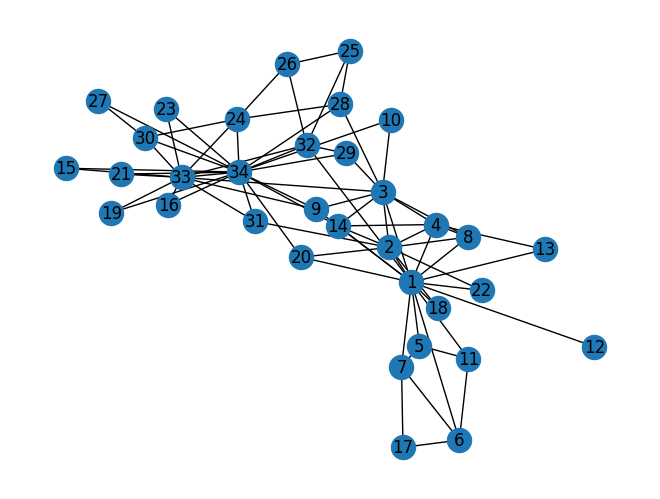

In [12]:
# 可视化
pos = nx.spring_layout(G, seed=10)
nx.draw(G, pos, with_labels=True)
plt.show()

## 3. Alias Sampling

> 参考博客：
> 
> https://keithschwarz.com/darts-dice-coins/
> 
> https://www.bilibili.com/video/av798804262
>
> https://www.cnblogs.com/Lee-yl/p/12749070.html
>
> ![Algorithm](./Algorithm.png)

In [13]:
def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    # 事件个数
    K = len(probs)
    # q 关联 probs
    q = np.zeros(K)
    # J 别名 Alias
    J = np.zeros(K, dtype=np.int)
    
    # 两组
    smaller = []
    larger = []
    
    # 将各个概率分成两组，一组的概率值大于 1，另一组小于 1
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    # 贪心算法：概率小于 1 的不断填满
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q


In [14]:
def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)
    
    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk     # 取自己本来就对应的事件
    else:
        return J[kk]  # 取 Alias事件

In [22]:
def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int64)

    smaller = []
    larger = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

In [23]:
def get_alias_edge(src, dst):
    '''
    Get the alias edge setup lists for a given edge.
    '''
    p = args.p
    q = args.q
    
    unnormalized_probs = []
    
    # 论文 3.2.2 节核心算法，计算各条边的转移权重
    for dst_nbr in sorted(G.neighbors(dst)):
        if dst_nbr == src:
            unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
        elif G.has_edge(dst_nbr, src):
            unnormalized_probs.append(G[dst][dst_nbr]['weight'])
        else:
            unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
    
    # 归一化各条边的转移权重
    norm_const = sum(unnormalized_probs)
    normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

    # 执行 Alias Sampling
    return alias_setup(normalized_probs)

In [24]:
get_alias_edge(15,16)

(array([0, 0]), array([1.        , 0.99357163]))

In [25]:
is_directed = args.directed
alias_nodes = {}

# 节点概率 alias sampling 和归一化
for node in G.nodes():
    unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
    norm_const = sum(unnormalized_probs)
    normalized_probs = [float(u_prob)/norm_const for u_prob in unnormalized_probs]
    alias_nodes[node] = alias_setup(normalized_probs)
    # 信息展示
    if node == 25:
        print('25号结点')
        print(unnormalized_probs)
        print(norm_const)
        print(normalized_probs)
        print(alias_nodes[node])

25号结点
[0.6807489307264206, 1.7039250010430942, 0.18385477616710325]
2.568528707936618
[0.2650345813239083, 0.6633856167455151, 0.07157980193057671]
(array([1, 0, 1]), array([0.79510374, 1.        , 0.21473941]))


In [26]:
alias_edges = {}
triads = {}

# 边概率 alias sampling 和归一化
if is_directed:
    for edge in G.edges():
        alias_edges[edge] = get_alias_edge(edge[0], edge[1])
else:
    for edge in G.edges():
        alias_edges[edge] = get_alias_edge(edge[0], edge[1])
        alias_edges[(edge[1], edge[0])] = get_alias_edge(edge[1], edge[0])


In [27]:
# 每个节点的 J 表和 q 表（不考虑p、q 值）
alias_nodes

{1: (array([ 0,  0,  5,  1, 11,  3, 11, 12,  5, 12, 14,  8, 11, 14, 12, 14]),
  array([1.        , 0.6425057 , 0.29465205, 0.61082576, 0.1076844 ,
         0.3594496 , 0.79612633, 0.70443602, 0.24465772, 0.34230705,
         0.50457996, 0.11921612, 0.9465594 , 0.99729354, 0.79341524,
         0.42907092])),
 32: (array([2, 5, 0, 5, 5, 2]),
  array([0.85558317, 0.3825026 , 1.        , 0.61865947, 0.37842106,
         0.42721905])),
 22: (array([0, 0]), array([1.        , 0.41316383])),
 20: (array([0, 2, 0]), array([1.        , 0.29843255, 0.56513269])),
 18: (array([0, 0]), array([1.       , 0.4508068])),
 14: (array([0, 0, 4, 4, 1]),
  array([1.        , 0.7715804 , 0.06370072, 0.66173259, 0.51671535])),
 13: (array([1, 0]), array([0.90387139, 1.        ])),
 12: (array([0]), array([1.])),
 11: (array([0, 0, 0]), array([1.        , 0.62556891, 0.50557123])),
 9: (array([1, 0, 3, 1]),
  array([0.87874095, 1.        , 0.09857586, 0.81857191])),
 8: (array([3, 0, 3, 1]),
  array([0.93302

In [28]:
# 二阶随机游走（考虑 p、q 值）
alias_edges

{(1, 32): (array([2, 5, 0, 5, 5, 2]),
  array([0.85558317, 0.3825026 , 1.        , 0.61865947, 0.37842106,
         0.42721905])),
 (32,
  1): (array([ 0,  0,  5,  1, 11,  3, 11, 12,  5, 12, 14,  8, 11, 14, 12, 14]), array([1.        , 0.6425057 , 0.29465205, 0.61082576, 0.1076844 ,
         0.3594496 , 0.79612633, 0.70443602, 0.24465772, 0.34230705,
         0.50457996, 0.11921612, 0.9465594 , 0.99729354, 0.79341524,
         0.42907092])),
 (1, 22): (array([0, 0]), array([1.        , 0.41316383])),
 (22,
  1): (array([ 0,  0,  5,  1, 11,  3, 11, 12,  5, 12, 14,  8, 11, 14, 12, 14]), array([1.        , 0.6425057 , 0.29465205, 0.61082576, 0.1076844 ,
         0.3594496 , 0.79612633, 0.70443602, 0.24465772, 0.34230705,
         0.50457996, 0.11921612, 0.9465594 , 0.99729354, 0.79341524,
         0.42907092])),
 (1, 20): (array([0, 2, 0]), array([1.        , 0.29843255, 0.56513269])),
 (20,
  1): (array([ 0,  0,  5,  1, 11,  3, 11, 12,  5, 12, 14,  8, 11, 14, 12, 14]), array([1.        ,

## 4. 随机游走

### 生成一条随机游走序列

In [29]:
def node2vec_walk(walk_length, start_node):
    '''
    从指定的起始节点，生成一条随机游走序列
    '''
    # 从上一步计算出的 alias table, 完成 o(1) 的采样
    
    walk = [start_node]

    # 生成序列
    while len(walk) < walk_length:
        cur = walk[-1]
        # 邻居节点排序：为了和 alias table 计算时的顺序对应起来
        cur_nbrs = sorted(G.neighbors(cur))
        if len(cur_nbrs) > 0:
            if len(walk) == 1:
                walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
            else:
                # 看前一个节点prev
                prev = walk[-2]
                next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
                    alias_edges[(prev, cur)][1])]
                walk.append(next)
        else:
            break

    return walk

In [30]:
node2vec_walk(7, 3)

[3, 2, 31, 33, 31, 33, 21]

### 采样得到所有随机游走序列

In [35]:
def simulate_walks(num_walks, walk_length):
    '''
    图中每个节点作为起始点，生成 num_walks 个随机游走序列
    '''
    walks = []
    nodes = list(G.nodes())
    print('Walk iteration:')
    for walk_iter in range(num_walks):
        print(str(walk_iter+1), '/', str(num_walks))
        # 打乱节点顺序
        random.shuffle(nodes)
        for node in nodes:
            walks.append(node2vec_walk(walk_length=walk_length, start_node=node))

    return walks

In [36]:
simulate_walks(3, 7)

Walk iteration:
1 / 3
2 / 3
3 / 3


[[3, 29, 34, 33, 21, 33, 21],
 [32, 29, 3, 9, 34, 31, 2],
 [8, 1, 11, 1, 7, 5, 7],
 [14, 3, 9, 1, 6, 11, 1],
 [16, 33, 23, 34, 24, 34, 19],
 [10, 3, 33, 34, 30, 33, 30],
 [12, 1, 22, 2, 31, 2, 4],
 [26, 32, 34, 16, 34, 32, 26],
 [2, 31, 33, 24, 33, 16, 33],
 [18, 1, 9, 3, 9, 3, 28],
 [17, 6, 17, 6, 11, 1, 2],
 [20, 1, 11, 6, 11, 6, 1],
 [34, 24, 34, 14, 2, 8, 2],
 [25, 28, 25, 26, 32, 29, 3],
 [19, 33, 24, 34, 19, 34, 32],
 [30, 33, 21, 33, 21, 33, 21],
 [31, 2, 31, 33, 16, 33, 21],
 [7, 5, 7, 5, 1, 3, 1],
 [4, 3, 29, 3, 29, 34, 9],
 [6, 11, 5, 1, 12, 1, 22],
 [5, 1, 18, 1, 18, 1, 14],
 [28, 25, 28, 34, 24, 26, 25],
 [33, 30, 27, 30, 34, 14, 2],
 [22, 1, 13, 4, 2, 22, 1],
 [13, 1, 3, 10, 3, 29, 3],
 [11, 1, 14, 1, 3, 4, 8],
 [24, 28, 3, 2, 20, 34, 14],
 [29, 3, 29, 3, 9, 1, 18],
 [15, 33, 24, 33, 31, 33, 31],
 [23, 33, 31, 34, 9, 34, 16],
 [9, 33, 24, 34, 20, 34, 33],
 [21, 34, 16, 33, 21, 33, 19],
 [1, 4, 13, 1, 18, 1, 18],
 [27, 30, 27, 34, 31, 33, 34],
 [33, 16, 33, 16, 34, 33, 16],

In [37]:
print(f'num_walks: {args.num_walks}, walk_length: {args.walk_length}')

# 生成训练用的随机游走序列
walks = simulate_walks(args.num_walks, args.walk_length)

num_walks: 10, walk_length: 80
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [38]:
len(walks)

340

In [39]:
walks[0]

[15,
 34,
 16,
 33,
 31,
 33,
 16,
 33,
 9,
 3,
 1,
 2,
 8,
 1,
 3,
 9,
 1,
 3,
 1,
 22,
 1,
 3,
 1,
 22,
 1,
 5,
 1,
 7,
 1,
 12,
 1,
 22,
 1,
 9,
 3,
 4,
 3,
 29,
 34,
 9,
 1,
 5,
 1,
 32,
 1,
 11,
 1,
 9,
 1,
 8,
 1,
 18,
 2,
 8,
 4,
 13,
 1,
 6,
 17,
 6,
 11,
 5,
 11,
 1,
 11,
 5,
 7,
 1,
 8,
 2,
 8,
 2,
 4,
 3,
 1,
 22,
 1,
 5,
 7,
 1]

In [40]:
# 将 node 的 int 转为 string
walk_str = []
for walk in walks:
    tmp = []
    for node in walk:
        tmp.append(str(node))
    walk_str.append(tmp)

In [41]:
len(walk_str)

340

In [43]:
walk_str[0]

['15',
 '34',
 '16',
 '33',
 '31',
 '33',
 '16',
 '33',
 '9',
 '3',
 '1',
 '2',
 '8',
 '1',
 '3',
 '9',
 '1',
 '3',
 '1',
 '22',
 '1',
 '3',
 '1',
 '22',
 '1',
 '5',
 '1',
 '7',
 '1',
 '12',
 '1',
 '22',
 '1',
 '9',
 '3',
 '4',
 '3',
 '29',
 '34',
 '9',
 '1',
 '5',
 '1',
 '32',
 '1',
 '11',
 '1',
 '9',
 '1',
 '8',
 '1',
 '18',
 '2',
 '8',
 '4',
 '13',
 '1',
 '6',
 '17',
 '6',
 '11',
 '5',
 '11',
 '1',
 '11',
 '5',
 '7',
 '1',
 '8',
 '2',
 '8',
 '2',
 '4',
 '3',
 '1',
 '22',
 '1',
 '5',
 '7',
 '1']

## 5. 训练 Node2Vec 模型

In [45]:
model = Word2Vec(walk_str,
                 vector_size=args.dimensions,
                 window=args.window_size,
                 min_count=0,
                 sg=1,
                 workers=args.workers
                )

# 保存 embedding 文件
model.wv.save_word2vec_format(args.output)

## 6. 结果分析和可视化

### 初始查看

In [48]:
# 查看 Node Embedding
print(model.wv.get_vector('17').shape)
model.wv.get_vector('17')

(128,)


array([ 0.16724674, -0.13952175,  0.26621443, -0.22661257, -0.05718328,
       -0.17310508, -0.11870964,  0.04631798, -0.1076628 ,  0.04175918,
        0.42770767,  0.12852219, -0.16507342, -0.24783315,  0.2707563 ,
       -0.24462646,  0.05123994, -0.10009252,  0.16894078, -0.11895169,
        0.00327661, -0.09754173,  0.02431392,  0.00711845, -0.15735991,
        0.21914059, -0.16657408,  0.12196659,  0.378566  , -0.02026015,
       -0.19584452,  0.31168988, -0.11469018,  0.07922155,  0.04667115,
       -0.04852546,  0.28723127,  0.07385018,  0.15145211, -0.04647034,
        0.23984528,  0.03729026, -0.03148436,  0.0139302 ,  0.20669079,
       -0.27808356,  0.07353921, -0.2810704 ,  0.03707767, -0.01525026,
        0.25332135, -0.4189023 , -0.06856108,  0.1414477 ,  0.15369041,
        0.03134132, -0.05591465,  0.03445198, -0.22075224, -0.00131061,
       -0.02656722, -0.15535761,  0.1464479 ,  0.01929879,  0.05530844,
       -0.00581094,  0.21394432,  0.05997645,  0.02893656, -0.39

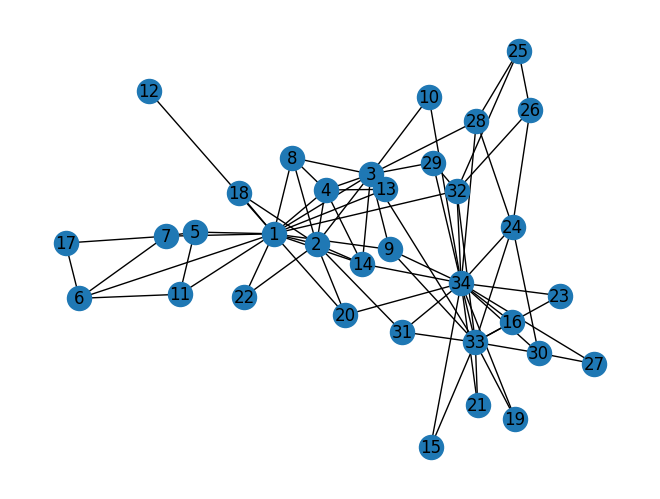

In [49]:
# 查找相似节点
pos = nx.spring_layout(G, seed=4)
nx.draw(G, pos, with_labels=True)
plt.show()

In [51]:
# 节点对相似度
print(model.wv.similarity('25', '26'))
print(model.wv.similarity('17', '25'))

# 找到最相似的节点
print(model.wv.most_similar('25'))

0.9614885
0.18591955
[('28', 0.9733460545539856), ('32', 0.9669627547264099), ('26', 0.9614884853363037), ('29', 0.8846335411071777), ('24', 0.8682335019111633), ('9', 0.8530513644218445), ('3', 0.7944749593734741), ('10', 0.7855256199836731), ('34', 0.7792954444885254), ('16', 0.6859427094459534)]


In [52]:
# 自定义相似性距离度量指标
from scipy import spatial

def cos_similarity(v1, v2):
    # 余弦相似度
    return 1 - spatial.distance.cosine(v1, v2)

v1 = model.wv.get_vector('25')
v2 = model.wv.get_vector('26')

cos_similarity(v1, v2)

0.9614885030987406

### 聚类分析

In [57]:
# KMeans 聚类
from sklearn.cluster import KMeans
import numpy as np

X = model.wv.vectors
cluster_labels = KMeans(n_clusters=3, random_state=9).fit(X).labels_

print(cluster_labels)

[0 1 0 1 1 1 1 2 0 1 0 0 0 2 0 0 0 0 1 1 0 1 0 1 2 2 0 2 0 1 0 0 1 2]


In [58]:
colors = []
for node in list(G.nodes()):
    idx = model.wv.key_to_index[str(node)]
    colors.append(cluster_labels[idx])

print(colors)

[1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


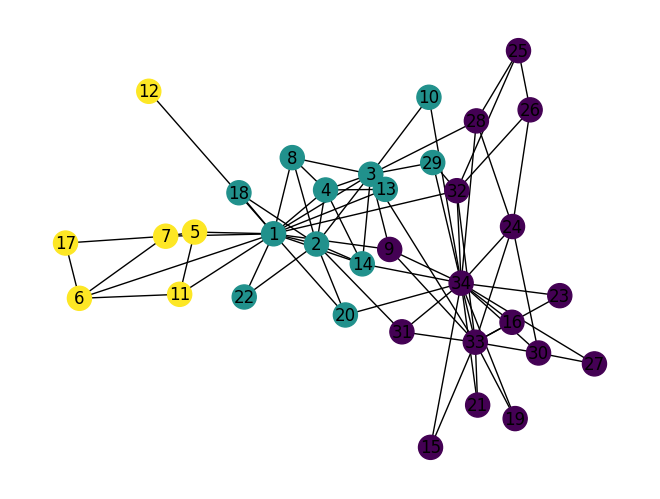

In [59]:
pos = nx.spring_layout(G, seed=4)
nx.draw(G, pos, node_color=colors, with_labels=True)
plt.show()

## 7. 附录*

### node2vec.py

In [61]:
import numpy as np
import networkx as nx
import random


class Graph():
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q

    def node2vec_walk(self, walk_length, start_node):
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        while len(walk) < walk_length:
            cur = walk[-1]
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                else:
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length):
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print('Walk iteration:')
        for walk_iter in range(num_walks):
            print(str(walk_iter+1), '/', str(num_walks))
            random.shuffle(nodes)
            for node in nodes:
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        for node in G.nodes():
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
            alias_nodes[node] = alias_setup(normalized_probs)

        alias_edges = {}
        triads = {}

        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return


def alias_setup(probs):
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]

### main.py

In [ ]:
'''
Reference implementation of node2vec. 

Author: Aditya Grover

For more details, refer to the paper:
node2vec: Scalable Feature Learning for Networks
Aditya Grover and Jure Leskovec 
Knowledge Discovery and Data Mining (KDD), 2016
'''

import argparse
import numpy as np
import networkx as nx
import node2vec
from gensim.models import Word2Vec

def parse_args():
    '''
    Parses the node2vec arguments.
    '''
    parser = argparse.ArgumentParser(description="Run node2vec.")

    parser.add_argument('--input', nargs='?', default='graph/karate.edgelist',
                        help='Input graph path')

    parser.add_argument('--output', nargs='?', default='emb/karate.emb',
                        help='Embeddings path')

    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')

    parser.add_argument('--walk-length', type=int, default=80,
                        help='Length of walk per source. Default is 80.')

    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.')

    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')

    parser.add_argument('--iter', default=1, type=int,
                      help='Number of epochs in SGD')

    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')

    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')

    parser.add_argument('--q', type=float, default=1,
                        help='Inout hyperparameter. Default is 1.')

    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)

    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)

    return parser.parse_args(args=[])

def read_graph():
    '''
    Reads the input network in networkx.
    '''
    if args.weighted:
        G = nx.read_edgelist(args.input, nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(args.input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not args.directed:
        G = G.to_undirected()

    return G

def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [map(str, walk) for walk in walks]
    model = Word2Vec(walks, size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers, iter=args.iter)
    model.save_word2vec_format(args.output)

    return

def main(args):
    '''
    Pipeline for representational learning for all nodes in a graph.
    '''
    nx_G = read_graph()
    G = node2vec.Graph(nx_G, args.directed, args.p, args.q)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(args.num_walks, args.walk_length)
    learn_embeddings(walks)

if __name__ == "__main__":
    args = parse_args()
    main(args)
